# Imports e carregamentos

In [1]:
import pandas as pd

import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

In [3]:
df.value_counts('result')

result
0    483769
1    158536
Name: count, dtype: int64

In [4]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway', 'shotsHome',
       'shotsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRiskHome', 'passRiskAway',
       'defensiveDiscipline', 'defensiveEfficacy', 'defensiveAggression',
       'timeSinceLastEvent_Home', 'timeSinceLastEvent_Away',
       'timeSinceLastEventShots_Home', 'timeSinceLastEventShots_Away',
       'timeSinceLastEventPasses_Home', 'timeSinceLastEventPasses_Away',
       'timeSinceLastEventFouls_Home', 'timeSinceLastEventFouls_Away',
       'timeSinceLastEventTotalCards_Ho

## Preprocessamento

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    return preprocessor.fit(X)
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)

# Salvando o preprocessador para uso futuro
pickle.dump(preprocessor, open('../models/preprocessor.pickle', 'wb'))

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)


                                                                                   
Generation 1 - Current best internal CV score: 0.7531098931311282
                                                                                  
Generation 2 - Current best internal CV score: 0.7754804983821735
                                                                                  
Generation 3 - Current best internal CV score: 0.7754804983821735
                                                                                
Generation 4 - Current best internal CV score: 0.8018620395147513
                                                             
Generation 5 - Current best internal CV score: 0.8177559689722337
                                                             
Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=9, min_child_weight=7, n_estimators=100, n_jobs=1, subsample=0.6000000000000001, verbosity=0)


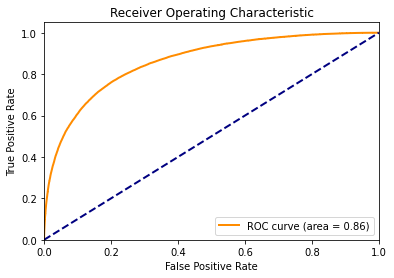

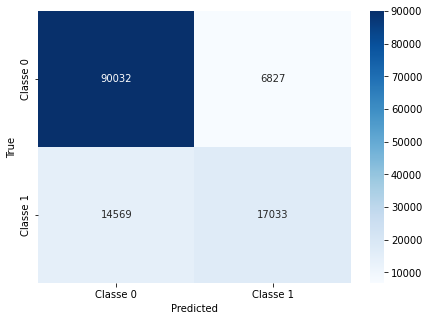

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.86      0.93      0.89     96859
    Classe 1       0.71      0.54      0.61     31602

    accuracy                           0.83    128461
   macro avg       0.79      0.73      0.75    128461
weighted avg       0.82      0.83      0.83    128461



In [8]:
from tpot import TPOTClassifier
from sklearn.metrics import classification_report

# Inicializando TPOT
tpot = TPOTClassifier(n_jobs=2, generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Salvando o pipeline otimizado
# tpot.export('tpot_exported_pipeline.py')

# Avaliação do Modelo
y_pred_prob = tpot.predict_proba(X_test)[:, 1]  # pegar as probabilidades da classe 1
y_pred = tpot.predict(X_test)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1']))


In [36]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


num_negatives = 96859  # Soma da coluna da Classe 0
num_positives = 31602  # Soma da coluna da Classe 1

scale_pos_weight = num_negatives / num_positives

xgb_model = XGBClassifier(learning_rate=1.0, max_depth=9, min_child_weight=7, n_estimators=100, n_jobs=-1, subsample=0.6000000000000001)

# Treinar o modelo ajustado
xgb_model.fit(X_train, y_train)

# Fazer previsões
y_pred = xgb_model.predict(X_test)

# Avaliar o modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[89915  6944]
 [14334 17268]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     96859
           1       0.71      0.55      0.62     31602

    accuracy                           0.83    128461
   macro avg       0.79      0.74      0.76    128461
weighted avg       0.83      0.83      0.83    128461



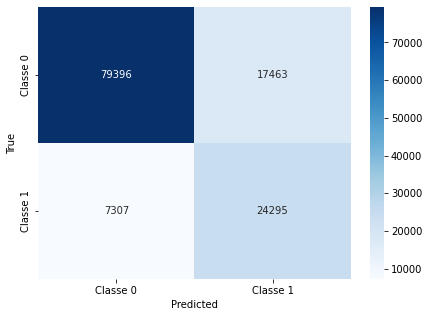

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.92      0.82      0.87     96859
    Classe 1       0.58      0.77      0.66     31602

    accuracy                           0.81    128461
   macro avg       0.75      0.79      0.76    128461
weighted avg       0.83      0.81      0.82    128461



In [13]:
# Fazendo previsões
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# # Curva ROC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# # Visualizando a curva ROC
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizando a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de Classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1']))

In [10]:



# Inicializando o modelo XGBClassifier
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, verbosity=1)

# Definindo os parâmetros para a busca em grade
parameters = {
    'max_depth': [8, 9, 10],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'min_child_weight': [1, 5, 10]
}

# Configurando a busca em grade com validação cruzada
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=2
)

# Executando a busca em grade no conjunto de dados de treino
# X_train, y_train = ...
grid_search.fit(X_train, y_train)

# Melhores parâmetros e melhor pontuação
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print('Melhores parâmetros:', best_parameters)
print('Melhor pontuação AUC:', best_score)

# Treinar o modelo com os melhores parâmetros encontrados
best_xgb = XGBClassifier(**best_parameters)
best_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


KeyboardInterrupt: 

In [9]:
# Salvar o modelo TPOT
with open('../models/tpot_model.pkl', 'wb') as file:
    pickle.dump(tpot.fitted_pipeline_, file)

In [ ]:
df.head(1699).tail(1)['result']

1698    0
Name: result, dtype: int64

In [ ]:
model_Automl = pickle.load(open('../models/tpot_model.pkl', 'rb'))

# na prática
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
yht = df['result'].head(1699).tail(1)

model_Automl.predict(Xht)[0] > 0  # pegar as probabilidades da classe 1

False

In [ ]:
model_Automl = pickle.load(open('../models/tpot_model.pkl', 'rb'))
from sklearn.metrics import accuracy_score

# avaliando treino e teste
y_pred_prob = model_Automl.predict_proba(X_train)[:, 1]  # pegar as probabilidades da classe 1
y_pred = model_Automl.predict(X_train)
print('Acurácia treino:', accuracy_score(y_train, y_pred))

y_pred_prob = model_Automl.predict_proba(X_test)[:, 1]  # pegar as probabilidades da classe 1
y_pred = model_Automl.predict(X_test)
print('Acurácia teste:', accuracy_score(y_test, y_pred))



Acurácia treino: 0.999564690418068
Acurácia teste: 0.8589962444520314
